In [2]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [3]:
#Load training set images
train_images=[]
train_image_names=[]

for file_name in os.listdir('./DataBase'):
    train_images.append(cv2.imread('./DataBase/'+file_name,2))
    train_image_names.append(file_name)

train_images = np.asarray(train_images,dtype=np.float32)/255

In [4]:
#Load test set images
test_images=[]
test_image_names=[]

for file_name in os.listdir('./test'):
    test_images.append(cv2.imread('./test/'+file_name,2))
    test_image_names.append(file_name)

test_images = np.asarray(test_images,dtype=np.float32)/255

In [5]:
class PCA:
    def __init__(self):
        self.eigvec_sorted =[]
    
    def train(self, train_data):

        #Flatten input
        flat_data=[np.asarray(data).flatten() for data in train_data]
        
        #Subtract mean
        mean = np.mean(flat_data,axis=0)
        flat_data = flat_data - mean

        #Calculate covariance matrix
        cov_matrix = np.cov(flat_data, rowvar=False)

        #Calculate eigenvectors and sort them according to eigenvalues

        eigval, eigvec = np.linalg.eigh(cov_matrix)
        eigvec=eigvec.T

        combined = list(zip(eigval,eigvec))
        combined.sort(reverse=True, key=lambda x: x[0])

        _, self.eigvec_sorted = zip(*combined)

    def encode(self, input, n_components):

        #Flatten input and keep original shape
        shape = input.shape
        flat_data=[np.asarray(data).flatten() for data in input]
        
        encoded_data = np.dot(self.eigvec_sorted[:n_components], np.asarray(flat_data).T).T

        return shape, encoded_data
    
    def decode(self ,input, shape, n_components):

        decoded_data = np.dot(np.asarray(self.eigvec_sorted[:n_components]).T, input.T).T
        decoded_data = decoded_data.reshape(shape)
        return decoded_data

    def run(self, test_data, n_components):

        shape, encoded_data = self.encode(test_data, n_components)
        decoded_data = self.decode(encoded_data,shape, n_components)

        return decoded_data


If the PCA model is already trained and saved you can skip the two next cells and run the other ones directly

In [40]:
#Creating and training the PCA model on the training images dataset

pca = PCA()
pca.train(train_images)

In [37]:
with open('./models/pca', 'wb') as output:
    pickle.dump(pca,output)

In [6]:
with open('./models/pca', 'rb') as input:
    pca = pickle.load(input)

In [7]:
def successful_retrieval(test, test_names, train, train_names):
    success_rate=0

    for i, test_img in enumerate(test):

        mean_diff = [np.mean((train_img-test_img)**2)for train_img in train]
        
        if test_names[i] == train_names[np.argmin(mean_diff)]:
            success_rate+=1

    return success_rate

In [302]:
enc_train_imgs=[]

for img in train_images:
   enc_train_imgs.append(pca.encode(np.array([img]),100)[1])

enc_test_imgs=[]

for img in test_images:
   enc_test_imgs.append(pca.encode(np.array([img]),100)[1])


result_100 = successful_retrieval(enc_test_imgs,test_image_names,enc_train_imgs, train_image_names)


print("=========================================================")
print("PCA (100 components): " + str(result_100) +"/10")

enc_train_imgs=[]

for img in train_images:
   enc_train_imgs.append(pca.encode(np.array([img]),50)[1])

enc_test_imgs=[]

for img in test_images:
   enc_test_imgs.append(pca.encode(np.array([img]),50)[1])


result_50 = successful_retrieval(enc_test_imgs,test_image_names,enc_train_imgs, train_image_names)


print("=========================================================")
print("PCA (50 components): " + str(result_50) +"/10")


enc_train_imgs=[]

for img in train_images:
   enc_train_imgs.append(pca.encode(np.array([img]),10)[1])

enc_test_imgs=[]

for img in test_images:
   enc_test_imgs.append(pca.encode(np.array([img]),10)[1])


result_10= successful_retrieval(enc_test_imgs,test_image_names,enc_train_imgs, train_image_names)


print("=========================================================")
print("PCA (10 components): " + str(result_10) +"/10")

PCA (100 components): 6/10
PCA (50 components): 6/10
PCA (10 components): 4/10


In [304]:
with open('./results/pca_100', 'wb') as output:
    pickle.dump(result_100, output)

with open('./results/pca_50', 'wb') as output:
    pickle.dump(result_50, output)

with open('./results/pca_10', 'wb') as output:
    pickle.dump(result_10, output)

In [8]:
test_images_100 = pca.run(test_images,100)
test_images_50 = pca.run(test_images,50)
test_images_10 = pca.run(test_images,10)

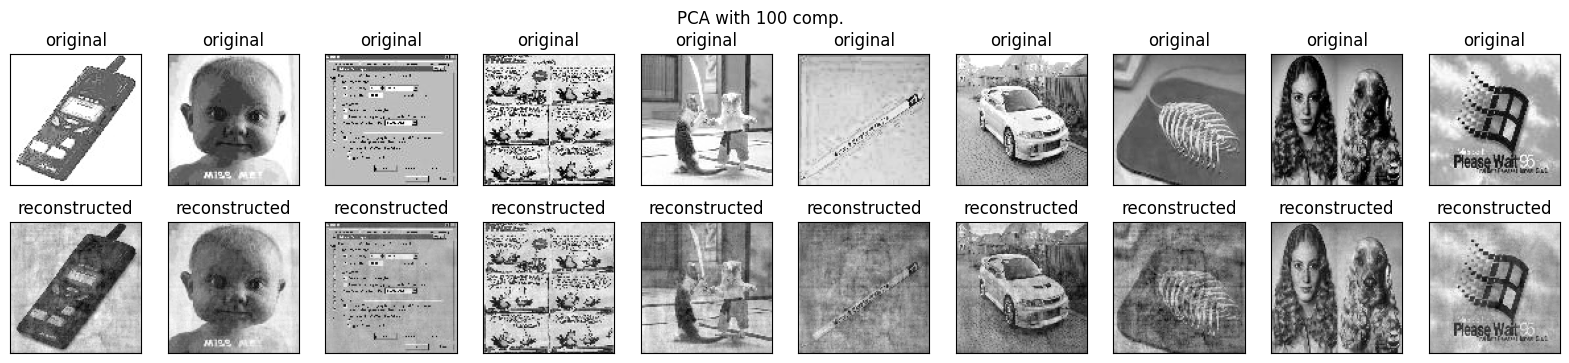

In [10]:
n = 10
fig = plt.figure(figsize=(20, 4))
fig.suptitle("PCA with 100 comp.")
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(test_images[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(test_images_100[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.savefig('./images/pca_100.png')
plt.show()

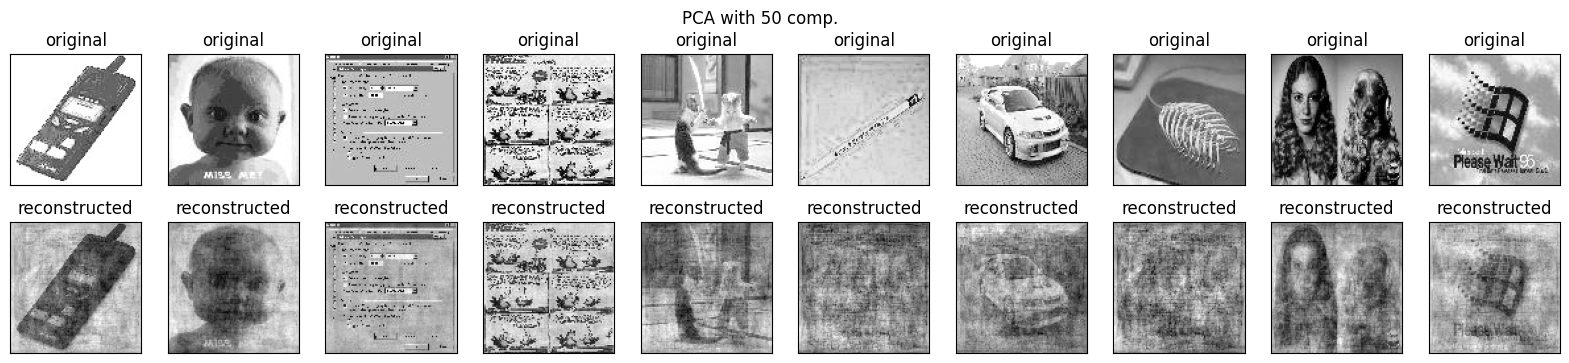

In [11]:
n = 10
fig = plt.figure(figsize=(20, 4))
fig.suptitle("PCA with 50 comp.")
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(test_images[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(test_images_50[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.savefig('./images/pca_50.png')
plt.show()

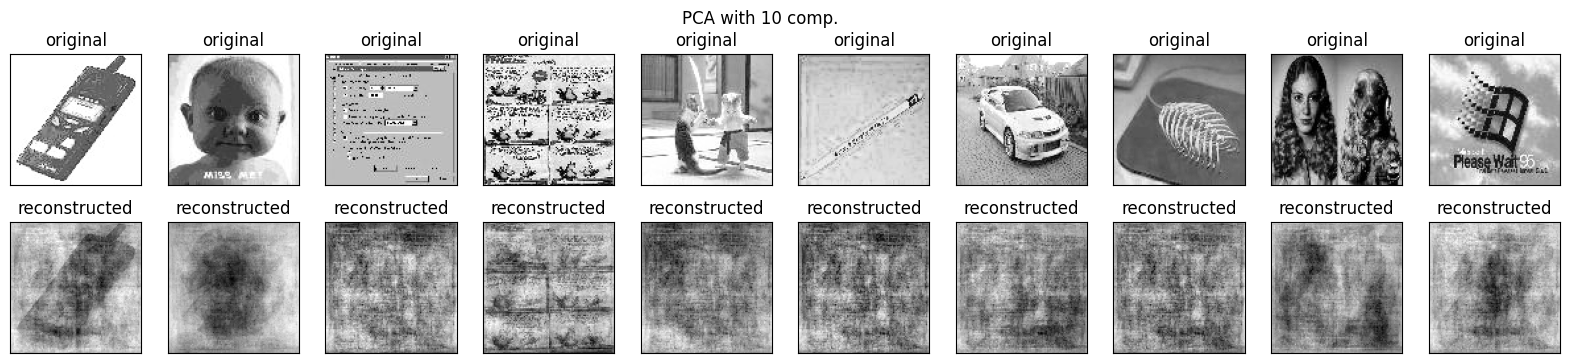

In [12]:
n = 10
fig = plt.figure(figsize=(20, 4))
fig.suptitle("PCA with 10 comp.")
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(test_images[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(test_images_10[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.savefig('./images/pca_10.png')
plt.show()